In [1]:
import gymnasium as gym
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from cellitaire.environment.cellitaire_env import CellitaireEnv
from cellitaire.environment.rewards.reward import *

In [2]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches
        
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        self.actions.append(action)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

In [3]:
class ActorNetwork(nn.Module):
    def __init__(
        self, 
        n_actions, 
        input_dims, 
        alpha,
        chkpt_dir='tmp/ppo', 
        num_embeddings=53, 
        embedding_dim=30, 
        embeddings_in_state=85,
        num_hidden_layers=1,
        hidden_dim=256
    ):
        super(ActorNetwork, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim).to(self.device)
        self.embeddings_in_state = embeddings_in_state
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(input_dims[0] - self.embeddings_in_state + (self.embeddings_in_state * embedding_dim), hidden_dim),
            nn.ReLU()
        )
        
        for _ in range(num_hidden_layers):
            self.actor.append(nn.Linear(hidden_dim, hidden_dim))
            self.actor.append(nn.ReLU())
        
        self.actor.append(nn.Linear(hidden_dim, n_actions))
        self.actor.append(nn.Softmax(dim=-1))
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)
        
        self.n_actions = n_actions

    def forward(self, state):
        embeddings = self.embedding_layer(state[:, :self.embeddings_in_state].int()).view(state.shape[0], 1, -1)
        state = state.view(state.shape[0], 1, -1)[:, :, self.embeddings_in_state:]
        state = torch.concatenate((state, embeddings), dim=2)
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist
    
    '''
    def forward_with_mask(self, state, legal_actions):
        embeddings = self.embedding_layer(state[:, :self.embeddings_in_state].int()).view(state.shape[0], 1, -1)
        state = state.view(state.shape[0], 1, -1)[:, :, self.embeddings_in_state:]
        state = torch.concatenate((state, embeddings), dim=2)
        dist = self.actor(state)
        legal_actions_mask = torch.full((state.shape[0], 1, self.n_actions), -1e9)
        for action in legal_actions:
            legal_actions_mask[0, 0, action] = 1
        print(legal_actions_mask.shape)
        print(dist.shape)
        dist = dist * legal_actions_mask
        dist = Categorical(dist)
        
        return dist
    '''

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [4]:
class CriticNetwork(nn.Module):
    def __init__(
        self, 
        input_dims, 
        alpha, 
        fc1_dims=256, 
        fc2_dims=256, 
        chkpt_dir='tmp/ppo'
    ):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [5]:
class Agent:
    def __init__(
        self, 
        n_actions, 
        input_dims, 
        gamma=0.99, 
        alpha=0.0003, 
        gae_lambda=0.95,
        policy_clip=0.2, 
        batch_size=64, 
        n_epochs=10,
        num_hidden_layers_actor=1,
        hidden_dim_actor=256
    ):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.n_actions = n_actions

        self.actor = ActorNetwork(
            n_actions, 
            input_dims, 
            alpha, 
            num_hidden_layers=num_hidden_layers_actor, 
            hidden_dim=hidden_dim_actor
        )
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = torch.tensor(np.array([observation]), dtype=torch.float).to(self.actor.device)
        
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               

In [10]:
test_reward = CombinedReward([
    PlacedCardInFoundationReward(weight=2),
    WinReward(),
    ConstantReward(weight=-0.1),
    PlayedLegalMoveReward(weight=1),
    PeriodicPlacedCardInFoundationReward(weight=2, reward_period=3)
])

In [11]:
print([reward.weight for reward in test_reward.rewards_list])

[2, 1000000, -0.1, 1, 2]


In [12]:
env = CellitaireEnv(test_reward)

In [ ]:
N = 20
batch_size = 3
n_epochs = 5
alpha = 0.0003
num_hidden_layers_actor=1
hidden_dim_actor=256
agent = Agent(
    n_actions=env.action_space.n, 
    input_dims=(7 * 12 + 6,), 
    batch_size=batch_size, 
    alpha=alpha, 
    n_epochs=n_epochs,
    num_hidden_layers_actor=num_hidden_layers_actor,
    hidden_dim_actor=hidden_dim_actor
)

n_games = 15000

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation, reward, done, truncated, info = env.reset()
    done = False
    score = 0
    while (not done) and (not truncated):
        #legal_actions = env.get_legal_actions_as_int()
        #print(legal_actions)
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, truncated, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    
    print(f'episode {i:>5} score {score:>6.1f} recent avg {avg_score:>6.1f} legal moves {env.num_moves:>3} cards saved {env.game.foundation.total_cards():>2}')

... saving models ...
episode     0 score  -10.8 recent avg  -10.8 legal moves  17 cards saved  1
episode     1 score  -13.9 recent avg  -12.3 legal moves  18 cards saved  0
episode     2 score  -16.6 recent avg  -13.8 legal moves  15 cards saved  0
episode     3 score   -5.7 recent avg  -11.7 legal moves  16 cards saved  3
episode     4 score  -16.2 recent avg  -12.6 legal moves  11 cards saved  1
episode     5 score   -8.0 recent avg  -11.9 legal moves  12 cards saved  0
episode     6 score   -5.9 recent avg  -11.0 legal moves  18 cards saved  2
... saving models ...
episode     7 score   -0.0 recent avg   -9.6 legal moves   6 cards saved  0
... saving models ...
episode     8 score   -1.1 recent avg   -8.7 legal moves  12 cards saved  0
episode     9 score  -12.8 recent avg   -9.1 legal moves  14 cards saved  0
... saving models ...
episode    10 score   -0.5 recent avg   -8.3 legal moves  24 cards saved  2
episode    11 score  -15.6 recent avg   -8.9 legal moves   6 cards saved  0


In [ ]:
plt.plot(torch.tensor(score_history, dtype=torch.float).view(-1, 100).mean(1))

In [1]:
env = gym.make("CartPole-v1", render_mode="human")
env.reset()
env.render()

NameError: name 'gym' is not defined

C:\Users\Noe\AppData\Local\Temp\ipykernel_9188\690304986.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\Users\dev-admin\Desktop\c_full\libtorch_1738968566392\work\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.tensor([observation], dtype=torch.float).to(self.actor.device)


... saving models ...
episode 0 score 19.0 avg score 19.0 time_steps 19 learning_steps 0
episode 1 score 19.0 avg score 19.0 time_steps 38 learning_steps 1
episode 2 score 19.0 avg score 19.0 time_steps 57 learning_steps 2
... saving models ...
episode 3 score 44.0 avg score 25.2 time_steps 101 learning_steps 5
... saving models ...
episode 4 score 38.0 avg score 27.8 time_steps 139 learning_steps 6
episode 5 score 21.0 avg score 26.7 time_steps 160 learning_steps 8
episode 6 score 14.0 avg score 24.9 time_steps 174 learning_steps 8
episode 7 score 12.0 avg score 23.2 time_steps 186 learning_steps 9
episode 8 score 10.0 avg score 21.8 time_steps 196 learning_steps 9
episode 9 score 15.0 avg score 21.1 time_steps 211 learning_steps 10
episode 10 score 25.0 avg score 21.5 time_steps 236 learning_steps 11
episode 11 score 15.0 avg score 20.9 time_steps 251 learning_steps 12
episode 12 score 18.0 avg score 20.7 time_steps 269 learning_steps 13
episode 13 score 21.0 avg score 20.7 time_step

... saving models ...
episode 100 score 135.0 avg score 76.3 time_steps 7651 learning_steps 382
... saving models ...
episode 101 score 77.0 avg score 76.9 time_steps 7728 learning_steps 386
... saving models ...
episode 102 score 104.0 avg score 77.8 time_steps 7832 learning_steps 391
... saving models ...
episode 103 score 162.0 avg score 78.9 time_steps 7994 learning_steps 399
... saving models ...
episode 104 score 142.0 avg score 80.0 time_steps 8136 learning_steps 406
... saving models ...
episode 105 score 171.0 avg score 81.5 time_steps 8307 learning_steps 415
... saving models ...
episode 106 score 238.0 avg score 83.7 time_steps 8545 learning_steps 427
... saving models ...
episode 107 score 161.0 avg score 85.2 time_steps 8706 learning_steps 435
... saving models ...
episode 108 score 142.0 avg score 86.5 time_steps 8848 learning_steps 442
... saving models ...
episode 109 score 730.0 avg score 93.7 time_steps 9578 learning_steps 478
... saving models ...
episode 110 score 2

episode 187 score 104.0 avg score 856.3 time_steps 91987 learning_steps 4599
episode 188 score 110.0 avg score 856.5 time_steps 92097 learning_steps 4604
episode 189 score 100.0 avg score 857.1 time_steps 92197 learning_steps 4609
episode 190 score 12.0 avg score 856.4 time_steps 92209 learning_steps 4610
episode 191 score 131.0 avg score 857.1 time_steps 92340 learning_steps 4617
episode 192 score 127.0 avg score 857.8 time_steps 92467 learning_steps 4623
episode 193 score 78.0 avg score 857.3 time_steps 92545 learning_steps 4627
episode 194 score 12.0 avg score 856.3 time_steps 92557 learning_steps 4627
episode 195 score 10.0 avg score 855.6 time_steps 92567 learning_steps 4628
episode 196 score 11.0 avg score 855.0 time_steps 92578 learning_steps 4628
episode 197 score 11.0 avg score 852.9 time_steps 92589 learning_steps 4629
episode 198 score 12.0 avg score 852.2 time_steps 92601 learning_steps 4630
episode 199 score 10.0 avg score 851.0 time_steps 92611 learning_steps 4630
episode

episode 292 score 8.0 avg score 1603.8 time_steps 252845 learning_steps 12642
episode 293 score 10.0 avg score 1603.1 time_steps 252855 learning_steps 12642
episode 294 score 9.0 avg score 1603.1 time_steps 252864 learning_steps 12643
episode 295 score 10.0 avg score 1603.1 time_steps 252874 learning_steps 12643
episode 296 score 9.0 avg score 1603.0 time_steps 252883 learning_steps 12644
episode 297 score 11.0 avg score 1603.0 time_steps 252894 learning_steps 12644
episode 298 score 10.0 avg score 1603.0 time_steps 252904 learning_steps 12645
episode 299 score 10.0 avg score 1603.0 time_steps 252914 learning_steps 12645


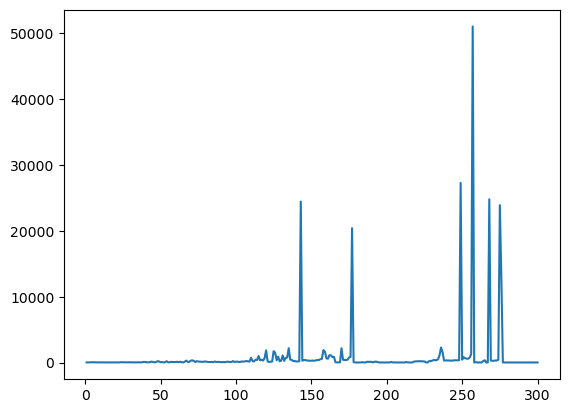

In [12]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.shape, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)

n_games = 300

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    (observation, _) = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, _, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score,'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)
x = [i + 1 for i in range(len(score_history))]
plt.plot(x, score_history)
env.close()

In [32]:
%pip install -e ../.

Obtaining file:///P:/repos/cellitaire-rl
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for cellitaire (pyproject.toml): started
  Building editable for cellitaire (pyproject.toml): finished with status 'done'
  Created wheel for cellitaire: filename=cellitaire-0.0.1-0.editable-py3-none-any.whl size=1307 sha256=abd36cab9a29c4bae2fb4bc6203232d252c22704dd97daeba65e075a317e3d22
  Stored in directory: C:\Users\Noe\AppData\Local\Temp\pip-ephem-wheel-cache-14ynjh2i\wheels\76\88\96\576254946bf13aa1d012dfa539e7e5e1fddd6ac7e334da0df2


In [3]:
%pip install gymnasium[classic-control]

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [86 lines of output]
  
  
  WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
  Using WINDOWS configuration...
  
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
      exec(compile('''
      ~~~~^^^^^^^^^^^^
      # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ...<31 lines>...
      exec(compile(setup_py_code, filename, "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ''' % ('C:\\Users\\Noe\\AppData\\Local\\Temp\\pip-install-eoyw7vpr\\pygame_967dc80c3fe74667b8820019c1335dad\\setup.py',), "<pip-setuptools-caller>", "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "<


  Using cached pygame-2.1.3.tar.gz (12.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


In [4]:
%pip install pygame

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------- ----------- 7.6/10.6 MB 42.4 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 37.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
